In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import Imputer
from astropy.io import fits
import urllib2, re
from matplotlib.pyplot import subplots
import functools
import multiprocessing
import thread
import Queue
import time
import random
from scipy.stats import linregress, kurtosis
import copy
from itertools import izip, imap
import sys
import warnings
print sys.version

import matplotlib as mpl

2.7.14 |Anaconda custom (64-bit)| (default, Oct 16 2017, 17:29:19) 
[GCC 7.2.0]


In [3]:
# Things to do:
# See if arcdrift is caused by movements out of aperture or 
# if movement of objects into different pixels amplify errors in those pixels
#
# Subtract off ICA components from light curves
# Do a kmeans plot on the components

class BasicFitsContainer:
    '''A smaller container for the hdu so we don't use as much memory'''
    total_mem = 0 # in bytes
    def __init__(self, hdu):
        
        if hdu.name == 'PRIMARY':
            self.header = {'KEPMAG':hdu.header['KEPMAG']}
        else:
            self.header = None
        if hdu.data is not None:
            self.data = np.array(hdu.data.tolist())[:,:3]
            BasicFitsContainer.total_mem += self.data.shape[0]*self.data.shape[1]*8
            
        else:
            self.data = hdu.data
        

In [4]:
FIX_PROBLEMS = False #Set to true if your computer is giving you trouble

class DownloadContainer(dict):
    '''performs downloads of LCs, but in another thread
    so we can access everything that's been downloaded so far '''
    
    def __init__(self, EPIC_List, campaign):
        self.EPIC_List = EPIC_List #This is a list of EPIC IDs, not a dict
        self.Queue = Queue.Queue(maxsize=len(EPIC_List))
        self.campaign = campaign
        self.downloads = []
        self.done = False
        thread.start_new_thread(self.download_all_lcs, (EPIC_List,))
        
    def download_all_lcs(self, EPIC_List=None):
        '''Will be run in a thread, populates the queue'''
        for epic in EPIC_List:
            if not self.done:
                try:
                    self.Queue.put(downloadLC(epic, campaign=self.campaign))
                except Exception as e:
                    print e
            else:
                print "KILLED"
                return
        self.Queue.join()
        self.done = True
        
    def extend(self, EPIC_List):
        '''add more objects to the container'''
        self.EPIC_List.extend(EPIC_List)
        if self.done:
            self.done = False
            thread.start_new_thread(self.download_all_lcs, (EPIC_List,))
        else:
            thread.start_new_thread(self.wait_till_done, (self.download_all_lcs, EPIC_List))
            
    def wait_till_done(self, func, *args):
        '''wait till the thread is done then execute func'''
        while not self.done:
            time.sleep(0.1)
            #print "waiting..."
        self.done = False
        thread.start_new_thread(func, args)
        
        
    def inspect(self):
        while not self.Queue.empty(): # Just to make sure we get everything we can cause we're greedy
            self.downloads.append(self.Queue.get())
            self.Queue.task_done()
        print "Completed", len(self.downloads), "out of", len(self.EPIC_List)
        print "Are we done?:", self.done
        
    def kill(self):
        self.done = True
    
    def __iter__(self):
        
        for d in self.downloads:
            yield d
        while not self.done: # Queue resets this once it's joined, unless killed which can cause problems
            #print "Iterating over the Queue"
            self.downloads.append(self.Queue.get())
            self.Queue.task_done()
            yield self.downloads[-1]
            
    def __getitem__(self, key):
        
        if isinstance(key, slice):
            return (self[i] for i in xrange(*key.indices(len(self.EPIC_List))))
        if isinstance(key, int):
            if key < len(self.downloads):
                return self.downloads[key]
            elif key < len(self.EPIC_List):
                for i, obj in enumerate(self): #Horrible lookup time here
                    if i == key:
                        return obj
                time.sleep(0.1)
                return self[key]
            else:
                raise IndexError, "The index (%d) is out of range."%key

def downloadLC(EPIC, func = None, campaign = 8): #Provide an EPIC ID (int), downloads appropriate LC
    # "Campaign=%02i" % campaign, EPIC
    filename = "http://archive.stsci.edu/missions/hlsp/k2sff/c%02i/" % (campaign)+\
        "%s00000/%s/hlsp_k2sff_k2_lightcurve_%s-c%02i_kepler_v1_llc.fits" % (str(EPIC)[:4], str(EPIC)[4:], str(EPIC), campaign)
    result = None
    #print EPIC
    for i in xrange(5): #Timeouts are common, just need to retry
        try:
            hdulist = fits.open(filename, memmap = True, cache = True) #Set memmap and cache to False if you get an error about too many open files
            if func is not None:
                result = func(hdulist)
                hdulist.close()
            else:
                result = {hdu.name:BasicFitsContainer(hdu) for hdu in hdulist}
                hdulist.close()
            del hdulist
            #print EPIC
            return result
        except urllib2.URLError:
            print "Timeout Error, Retrying: Attempt %i/5" % (i+1)
    print "LC Download Failed, Will Continue Without %s" % str(EPIC)
    print " ",filename
    return None
            
def getTimeIntersectionMasks(ts, minCounts = None): #Get positions where all time steps are the same within 1/1000 days
    ts = [(ts[i]*100).astype(int)/100.0 for i in xrange(len(ts))] #Truncate all times to 15 minutes
    intersection = reduce(np.intersect1d, ts) #Find all the points that are available in all data sets
    masks = (np.in1d(t, intersection, assume_unique=True) for t in ts) #Get the boolean array of the masks
    if minCounts is not None: #Make sure the LC has more than minCounts data points TODO: THIS IS INCORRECT
        masks = (m if np.sum(m) > minCounts else None for m in masks)
    return masks

#def getTimeIntersectionMasks(ts, minCounts=None):
#    '''same as before, but we're going to instead bin the times and use the largest bins'''

def getOutlierMask(lcs): #Mask of outliers in LC
    '''This really should do sigma clipping: TODO'''
    # Let's try doing a sort of running clip
    # Where we split the array into segments, clip outliers in those segments
    # then concatenate the segments back together
    #'''
    N = len(lcs)
    n = N/1
    masks = []
    for i in xrange(0, N, n):
        Lc = lcs[i:i+n]
        t = np.arange(len(Lc))
        s, i, r, p, s = linregress(t, Lc) # we'll try to quickly normalize to it's slope
        if any(np.isnan((s,i,r,p,s))):
            lc = Lc
        else:
            lc = Lc - s*t - i

        mean = np.mean(lc)
        std = np.std(lc)
        low = mean - 3*std
        high = mean + 3*std
        masks.append((lc < high) & (lc > low))
    return np.concatenate(masks)
    #'''
    #return (lcs > np.mean(lcs) - 3*np.std(lcs)) & (lcs < np.mean(lcs) + 3*np.std(lcs))

def Nlength_filter(N):
    '''returns a function used to filter objects with more than N points in the dataset'''
    def length_filter(data):
        t, l = data
        L = len(t)
        return L > N
    return length_filter

def filter_lcs(data):
    '''some function that filters out bad lightcurves'''
    #ts, lcs = data # just so we know the expected layout of 'data'
    #For now, let's just try the NaN filter at 200
    # So, it seems that there are no NaNs in the data, so let's cut be length
    return Nlength_filter(3000)(data)
    
def downloadLCData(EPIC_List, campaign=8):
    '''download the whole LC to cache for later'''
    
    return (downloadLC(EPIC, func=None, campaign=campaign) for EPIC in EPIC_List)

def multithreaded_download(EPIC_List, campaign=8):
    '''a function that downloads in a multithreaded fashion
    This thing is super hacky and error prone, don't use it '''
    download_func = functools.partial(downloadLC, campaign=campaign)

    N_files = len(EPIC_List)
    max_threads = 8
    thread_count = [0]
    download_queue = Queue.Queue(maxsize=N_files)
    def threaded_func(EPIC):
        #data = download_func(EPIC)
        download_queue.put(download_func(EPIC))
        thread_count[0] -= 1
    data = []
    for EPIC in EPIC_List:
        while thread_count[0] >= max_threads:
            time.sleep(0.1)
        thread.start_new_thread(threaded_func, (EPIC,))
        thread_count[0] += 1
    data = []
    while not download_queue.empty():
        #yield download_queue.get()
        data.append(download_queue.get())
    return data
    
def downloadLCList(data, corrected=True, clipOutliers = False, minCounts = None, ap = 1, dataFunc = None): #Takes a list of EPIC IDs
    
    if dataFunc is None: dataFunc = lambda x: np.asarray(x[ap].data.tolist()) #Convert the hdulists to fits tables, x[1] is BESTAPER
    # !!MAKE SURE WE WORK ON COPIES OF THE DATA SO WE DON"T SCREW WITH IT
    data = imap(dataFunc, data) # ~~The filter is to make sure we don't used timed out objects~~
    index = 2 if corrected else 1
    ts, lcs = izip(*(d[:,[0, index]].T for d in data)) #Put the cadences and fluxes into their own arrays
    
    if clipOutliers: #Find and Apply Outlier Mask
        masks = imap(getOutlierMask,lcs)
        # We can also set these to NaNs and use an SkLearn Imputer
        for l,m in izip(lcs,masks):
            l[~m] = np.nan
    
    masks = getTimeIntersectionMasks(ts, minCounts) #Find and apply time masks
    ts, lcs = zip(*((t[m], lc[m]) for (t,lc,m) in izip(ts, lcs, masks) if m is not None))

    return ts, lcs

def searchProposal(Proposal, campaign = 8): #Seach a proposal number for EPIC IDs, returns a dict with EPIC IDs as keys to RA and DEC coords

    socket = urllib2.urlopen('https://www.cfa.harvard.edu/~avanderb/allk2c%iobs.html' % campaign)
    body = socket.read()

    pattern = "EPIC (\d{9})</a>, Kp = (\d+\.\d+), RA = (\d+\.\d+), Dec = (-?\d+\.\d+).+%s" % Proposal
    matches = re.findall(pattern, body)
    socket.close()
    EPIC = [int(i[0]) for i in matches]
    coords = [(float(i[1]), float(i[2]), float(i[3])) for i in matches]
    Result = dict(zip(EPIC, coords))
    
    return Result

def apmap(i):
    if i == 1:
        return "BEST"
    string = ''
    if i < 12:
        string += 'CIRC'
    else:
        string += 'PRF'
        i -= 10
    return string + ' %i' % (i-2)

def magToFlux(mag):
    return 10**(-0.4*(mag-12))*1.74e5


def unnormDataFunc(ap):
    def unnormDataFunc2(hdulist):
        #res = np.asarray(hdulist[ap].data.tolist())
        res = np.array(hdulist[ap].data, copy=True)
        flux = magToFlux(hdulist['PRIMARY'].header['KEPMAG'])
        res[:,[1,2]] *= flux
        #res[:,1] *= flux
        return res
    return unnormDataFunc2

def CropLC(ap):
    def Crop(hdulist):
        res = np.array(hdulist[ap].data, copy=True)
        return res[len(res)/2:]
    return Crop

def polyfit(x, y, order=2):
    '''fit a polynomial of order 'order' to the dataset'''
    mask = ~(np.isnan(x) & np.isnan(y))
    return np.polyfit(x, y, order)

In [5]:
# Test polyfit
x = np.array(range(20))*1.0
y = np.array([x_**2+1 for x_ in x])
print polyfit(x, y)

[  1.00000000e+00  -1.48143654e-14   1.00000000e+00]


In [4]:
GO8052_LC = searchProposal("GO8052_LC")

In [20]:
# Generate the list of EPIC ids

campaigns = range(8,9)
prop = 'G'
EPIC_Lists = map(lambda x: searchProposal(prop, x), campaigns)
EPIC_Dict = dict(zip(campaigns, EPIC_Lists))
#print EPIC_Dict
for c in campaigns:
    print c
    for item in EPIC_Dict[c].items()[:3]:
        print " ", item[0],item[1]

epics = [220176624,
         220178456,
         220179771,
         229228893,
         220168331,
         229228948,
         229228901,
         220169790,
         220186429,
         220176138]
'''
epics = [220176624,
         220178456,
         220179771,
         229228893,
         220168331,
         229228948,
         229228901,
         220169790,
         220186429,
         220176138,
         220170097,
         220179872,
         220155373,
         229228937,
         229228953,
         220200836,
         229228896,
         229228897,
         220206173,
         220200310]'''
#epics = [220176624,220178456,220179771]

EPIC_Dict_filtered = {c:{k:v for k, v in EPIC_Dict[c].items() if str(k) in map(str, epics)} for c in campaigns }
#EPIC_Dict_filtered = {c:{k:v for k, v in EPIC_Dict[c].items() if str(k) in map(str, epics)} for c in campaigns }
#EPIC_Dict_filtered = {c:{k:v for k, v in EPIC_Dict[c].items() if v[0] > 17} for c in campaigns}
#EPIC_Dict_filtered = {c:{k:v for k, v in EPIC_Dict[c].items()} for c in campaigns}
# Cut the objects by magnitude so we only get faint source, does not guarantee QSOs

# This should be a dict indexed by campaign then by EPIC id containing a 3-tuple of MAG, RA, DEC
print map(lambda x: len(x[1].items()), EPIC_Dict_filtered.items())

sample_EPICS = EPIC_Dict_filtered
#sample_EPICS = dict(izip(campaigns, [dict(random.sample(EPIC_Dict_filtered[c].items(), 1000)) for c in campaigns]))
shortEPIC_Lists = sample_EPICS
print shortEPIC_Lists[8].keys()[:10]
print len(shortEPIC_Lists[8].keys())

8
  220463108 (11.659, 12.50452, 5.9456959)
  220200969 (15.483, 12.508751, 0.030408)
  220332050 (16.01, 13.270783, 3.319088)
[10]
[229228901, 220176138, 220168331, 220186429, 220176624, 229228948, 220178456, 220179771, 229228893, 220169790]
10


In [21]:
# Download the Lightcurves for later

# Do thisone if we know everything is cached
#FullLCData = {c:multithreaded_download(shortEPIC_Lists[c].keys()[:500], campaign=c) for c in campaigns}

# Do this one if we have to download new data
#FullLCData = {c:list(downloadLCData(shortEPIC_Lists[c].keys()[:500], campaign=c)) for c in campaigns}
# Careful, this this is a weird amalgamation of Queues, Generators, threads and dictionaries
# It *Should* be doing it's thing, and you *Should* be able to inspect it
# It's nice though because we can slice it at various intervals so we can test subsets before
# everything is done downloading
try:
    FullLCData[8].kill()
    FullLCData[8].inspect()
    del FullLCData
except:
    pass
FullLCData = {c:DownloadContainer(shortEPIC_Lists[c].keys()[:50], campaign=c) for c in campaigns}
# This is now indexed by CAMPAIGN X APERTURE

In [22]:
#for i,j in enumerate(FullLCData[8]):
#    print i
FullLCData[8].inspect()

Completed 0 out of 10
Are we done?: False


In [23]:
# We can choose to extend this list here if we want more items later!
#FullLCData[8].extend(shortEPIC_Lists[8].keys()[500:])

In [24]:
#FullLCData[8].inspect()
#FullLCData[8].kill() # This *Should* stop it's threads, careful of the queue joining

In [25]:
# We can 'warm up' the container by preemptively iterating over a slice to at least verify some of
# objects are immediately available
for i, j in enumerate(FullLCData[8][:100]):
    print i,
#print map(lambda x: x, FullLCData[8][:100])[0]
print ''
FullLCData[8].inspect()

0 1 2 3 4 5 6 7 8 9 
Completed 10 out of 10
Are we done?: True


In [26]:
# Now we can run everything past this point, unless we want more data
print FullLCData[8][0]
print "Total Memory:", BasicFitsContainer.total_mem/1000000.0 , 'MB'

{'CIRC_APER8': <__main__.BasicFitsContainer instance at 0x7ff440392f80>, 'CIRC_APER9': <__main__.BasicFitsContainer instance at 0x7ff4429427a0>, 'PRF_APER0': <__main__.BasicFitsContainer instance at 0x7ff442b6a200>, 'PRF_APER1': <__main__.BasicFitsContainer instance at 0x7ff442b36b48>, 'PRF_APER6': <__main__.BasicFitsContainer instance at 0x7ff442bc7b48>, 'PRF_APER7': <__main__.BasicFitsContainer instance at 0x7ff442ac0ea8>, 'PRF_APER4': <__main__.BasicFitsContainer instance at 0x7ff4407b40e0>, 'PRF_APER3': <__main__.BasicFitsContainer instance at 0x7ff442c55e18>, 'CIRC_APER0': <__main__.BasicFitsContainer instance at 0x7ff442f4f758>, 'CIRC_APER1': <__main__.BasicFitsContainer instance at 0x7ff442c97200>, 'CIRC_APER2': <__main__.BasicFitsContainer instance at 0x7ff442c975a8>, 'CIRC_APER3': <__main__.BasicFitsContainer instance at 0x7ff4426060e0>, 'CIRC_APER4': <__main__.BasicFitsContainer instance at 0x7ff4403799e0>, 'CIRC_APER5': <__main__.BasicFitsContainer instance at 0x7ff4425e73f8

In [27]:
aps = ['BESTAPER','CIRC_APER0','CIRC_APER4','CIRC_APER9'] #which apertures we want, others include "PRF_APERN"
#aps = ['CIRC_APER%i' % i for i in xrange(10)]
#aps = range(1,22)
#LCsList = [[downloadLCList(x, corrected=True, clipOutliers = True, minCounts = None, campaign = '0%i' % (k+1), ap = i, dataFunc = unnormDataFunc(i)) \
#            for (k, x) in enumerate(shortEPIC_Lists.items()) if k != 100] for i in aps] #APERTURE x CAMPAIGN x OBJECTS x (ts, lcs)


#LCData={c:FullLCData[c][:100] for c in campaigns}

#LCsList = [[downloadLCList(LCData[c], corrected=True, clipOutliers = True, \
#                           minCounts = None, ap = i, dataFunc = unnormDataFunc(i)) \
#            for c in campaigns] for i in aps] #APERTURE x CAMPAIGN x OBJECTS x (ts, lcs)

LCDict = {c:{ap:downloadLCList(FullLCData[c][:100], corrected=True, clipOutliers=True,\
                              minCounts=None, ap=ap, dataFunc=unnormDataFunc(ap))\
             for ap in aps}\
             for c in campaigns}

#LCDict = {c:{ap:downloadLCList(FullLCData[c][:50], corrected=True, clipOutliers=True,\
#                              minCounts=None, ap=ap, dataFunc=CropLC(ap))\
#             for ap in aps}\
#             for c in campaigns}

# Let's try doing campaign x aperture x object in dict tree form

In [28]:
#print LCsList[0][0][1][0][:4]

#verify no side effects
# APER X CAMP X (time, lc) X OBJECT
#print LCData[8][0]['CIRC_APER0'].data[:4,2]
print LCDict[8]['CIRC_APER4'][1][0][:4]
# CAMP x OBJECT X APER X (time, lc)

[ 449.71469936  458.80404695  439.00909351  457.48561398]


In [9]:
#means = [np.min(y[1], axis = 0) for y in LCsList[1]]
#print means[7]


In [10]:
#means = map(lambda x: map(np.mean, x), LCsList)
#stds = map(lambda x: map(np.std, x), LCsList)
'''
for k, ap in enumerate(aps):
    lcsList = LCsList[k]
    minCounts = None
    newLCsList = []
    newLCsList = lcsList

    means = [np.mean(y[1], axis = 0) for y in newLCsList]
    ts = [np.mean(y[0], axis = 0) for y in newLCsList]
    stds = [np.std(y[1], axis = 0) for y in newLCsList]

    fig, ax = subplots(1,1, figsize = [16,9])
    ap_map = lambda x: 'BEST' if x == 1 else str(x-2)
    cor = -12 if ap > 11 else 0
    fig.suptitle('Aperture %s' % (apmap(ap)))
   
    for i in xrange(8):
        if i != 7: continue
        if i == 1:
            continue
        if i > 1:
            i = i-1
        a = ax
        t = ts[i]#[stds[i] < 1]
        m = means[i]#[stds[i]<1]
        s = stds[i]#[stds[i]<1]
        
        #a.errorbar(t-min(t), newLCsList[i][1][1], ls = ' ', marker = 'o', markeredgecolor = 'none', label = 'testLC')
        if i > 0:
            i += 1
        a.errorbar(t - min(t), m,yerr = s*0, ls = ' ', marker = '.', label = 'campaign %i' %(i+1), markeredgecolor='none')

    ax.legend()
    #ax.set_ylim(1400,1750)
    plt.savefig("../Plots/FluxAperture%s%s.png" % ('' if  ap == 1 else ('CIRC' if ap < 11 else 'PRF'),  ap_map(ap+cor)))
    print ap_map(ap)
'''


'\nfor k, ap in enumerate(aps):\n    lcsList = LCsList[k]\n    minCounts = None\n    newLCsList = []\n    newLCsList = lcsList\n\n    means = [np.mean(y[1], axis = 0) for y in newLCsList]\n    ts = [np.mean(y[0], axis = 0) for y in newLCsList]\n    stds = [np.std(y[1], axis = 0) for y in newLCsList]\n\n    fig, ax = subplots(1,1, figsize = [16,9])\n    ap_map = lambda x: \'BEST\' if x == 1 else str(x-2)\n    cor = -12 if ap > 11 else 0\n    fig.suptitle(\'Aperture %s\' % (apmap(ap)))\n   \n    for i in xrange(8):\n        if i != 7: continue\n        if i == 1:\n            continue\n        if i > 1:\n            i = i-1\n        a = ax\n        t = ts[i]#[stds[i] < 1]\n        m = means[i]#[stds[i]<1]\n        s = stds[i]#[stds[i]<1]\n        \n        #a.errorbar(t-min(t), newLCsList[i][1][1], ls = \' \', marker = \'o\', markeredgecolor = \'none\', label = \'testLC\')\n        if i > 0:\n            i += 1\n        a.errorbar(t - min(t), m,yerr = s*0, ls = \' \', marker = \'.\', lab

In [11]:
#EPIC_List = GO8052_LC.keys() #All EPIC IDs in GO8052_LC


'''
EPIC_List = map(int, open("/home/rodot/Documents/Research/Data/k2/biasObjects.dat",'rb').read().strip().split())
EPIC_List = filter(lambda x: str(x).startswith('2201'), EPIC_List)#A smaller data sample
#EPIC_List = [220152700,220158771,220161074,220162066,220168966] #The original Data Points

print EPIC_List
print len(EPIC_List)
'''

'\nEPIC_List = map(int, open("/home/rodot/Documents/Research/Data/k2/biasObjects.dat",\'rb\').read().strip().split())\nEPIC_List = filter(lambda x: str(x).startswith(\'2201\'), EPIC_List)#A smaller data sample\n#EPIC_List = [220152700,220158771,220161074,220162066,220168966] #The original Data Points\n\nprint EPIC_List\nprint len(EPIC_List)\n'

Read in K2 Campaign 8 light curves downloaded from
https://www.cfa.harvard.edu/~avanderb/allk2c8obs.html

Started with 5 objects from GO8052_LC that don't appear to have nearby objects.
Will need to automate this to get all of them.

$t$ should be the same for all, so just take it from the first one

$lc*$ are the corrected light curves.  Might want to look at the raw light curves too/instead.

Ah, hell, the light curves don't all have the same $t$.  Probably because of bad data points that VJ14 reject.  Will need to figure out the minimum basis set of $t$ for all the objects and just use $lc$ data points at those $t$ values.  Fine, do that later.  For now, just take the first N data points and we'll fix it later.

In [12]:
'''
#Download all of the lcs and verify they all have close enough data points on the time axis
ts, lcs = downloadLCList(EPIC_List, corrected=True, clipOutliers = True, minCounts = None)
table = '\n'.join(map(' | '.join, zip(map(str,EPIC_List), map(str,map(len, ts)))))
print table
assert reduce(lambda x, y: x if (x==y) else False, map(len,ts)), "Arrays must all have same dimension\n   EPIC   | LENGTH\n%s" % table
'''

'\n#Download all of the lcs and verify they all have close enough data points on the time axis\nts, lcs = downloadLCList(EPIC_List, corrected=True, clipOutliers = True, minCounts = None)\ntable = \'\n\'.join(map(\' | \'.join, zip(map(str,EPIC_List), map(str,map(len, ts)))))\nprint table\nassert reduce(lambda x, y: x if (x==y) else False, map(len,ts)), "Arrays must all have same dimension\n   EPIC   | LENGTH\n%s" % table\n'

In [29]:
# LC filter
# We need to make sure we use good lightcurves
#
# First, let's try limiting the number of nans
# Problem: Looks like I'm already doing this filtering at the download step

def NNaN_filter(N):
    def NaN_filter(data):
        t, l = data
        N_NaN = np.sum(np.isnan(l))
        if N_NaN >= N:
            print N_NaN
        return N_NaN < N
    return NaN_filter

def apply_filter(filter_, lcdict):
    return {c:{ap:zip(*filter(filter_,izip(*LCDict[c][ap]))) for ap in aps} for c in campaigns}

LCDict_ = apply_filter(NNaN_filter(20), LCDict)
print len(LCDict_[8]['CIRC_APER9'][0])
        

        
def runningMean(x,N):
    return np.array([np.nanmean(x[i-N/2 if i > N/2 else i:i+N/2+(N%2)]) for i in xrange(len(x))])

def runningStd(x,N):
    return np.array([np.nanstd(x[i-N/2 if i > N/2 else 0:i+N/2 +(N%2)]) for i in xrange(len(x))])



def plotNiceIntervals(ax,x,y,N=30, label=None, color='k'):
    rm = runningMean(y,N)
    rs = runningStd(y,N)
    rs = runningMean(rs,N) #Make it nice and smooth
    
    ax.plot(x, y, ls=' ', marker='.', ms=1, color=color, label=label)
    ax.fill_between(x, rm+rs, rm-rs, color=color, alpha=0.1, linestyle='None')
    ax.plot(x, rm, ls='-', marker='.', ms=1, color=color, lw=1)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(np.nanmean(rm)-np.nanstd(rm)*3, np.nanmean(rm)+np.nanstd(rm)*3)

27
27
53
24
59
8


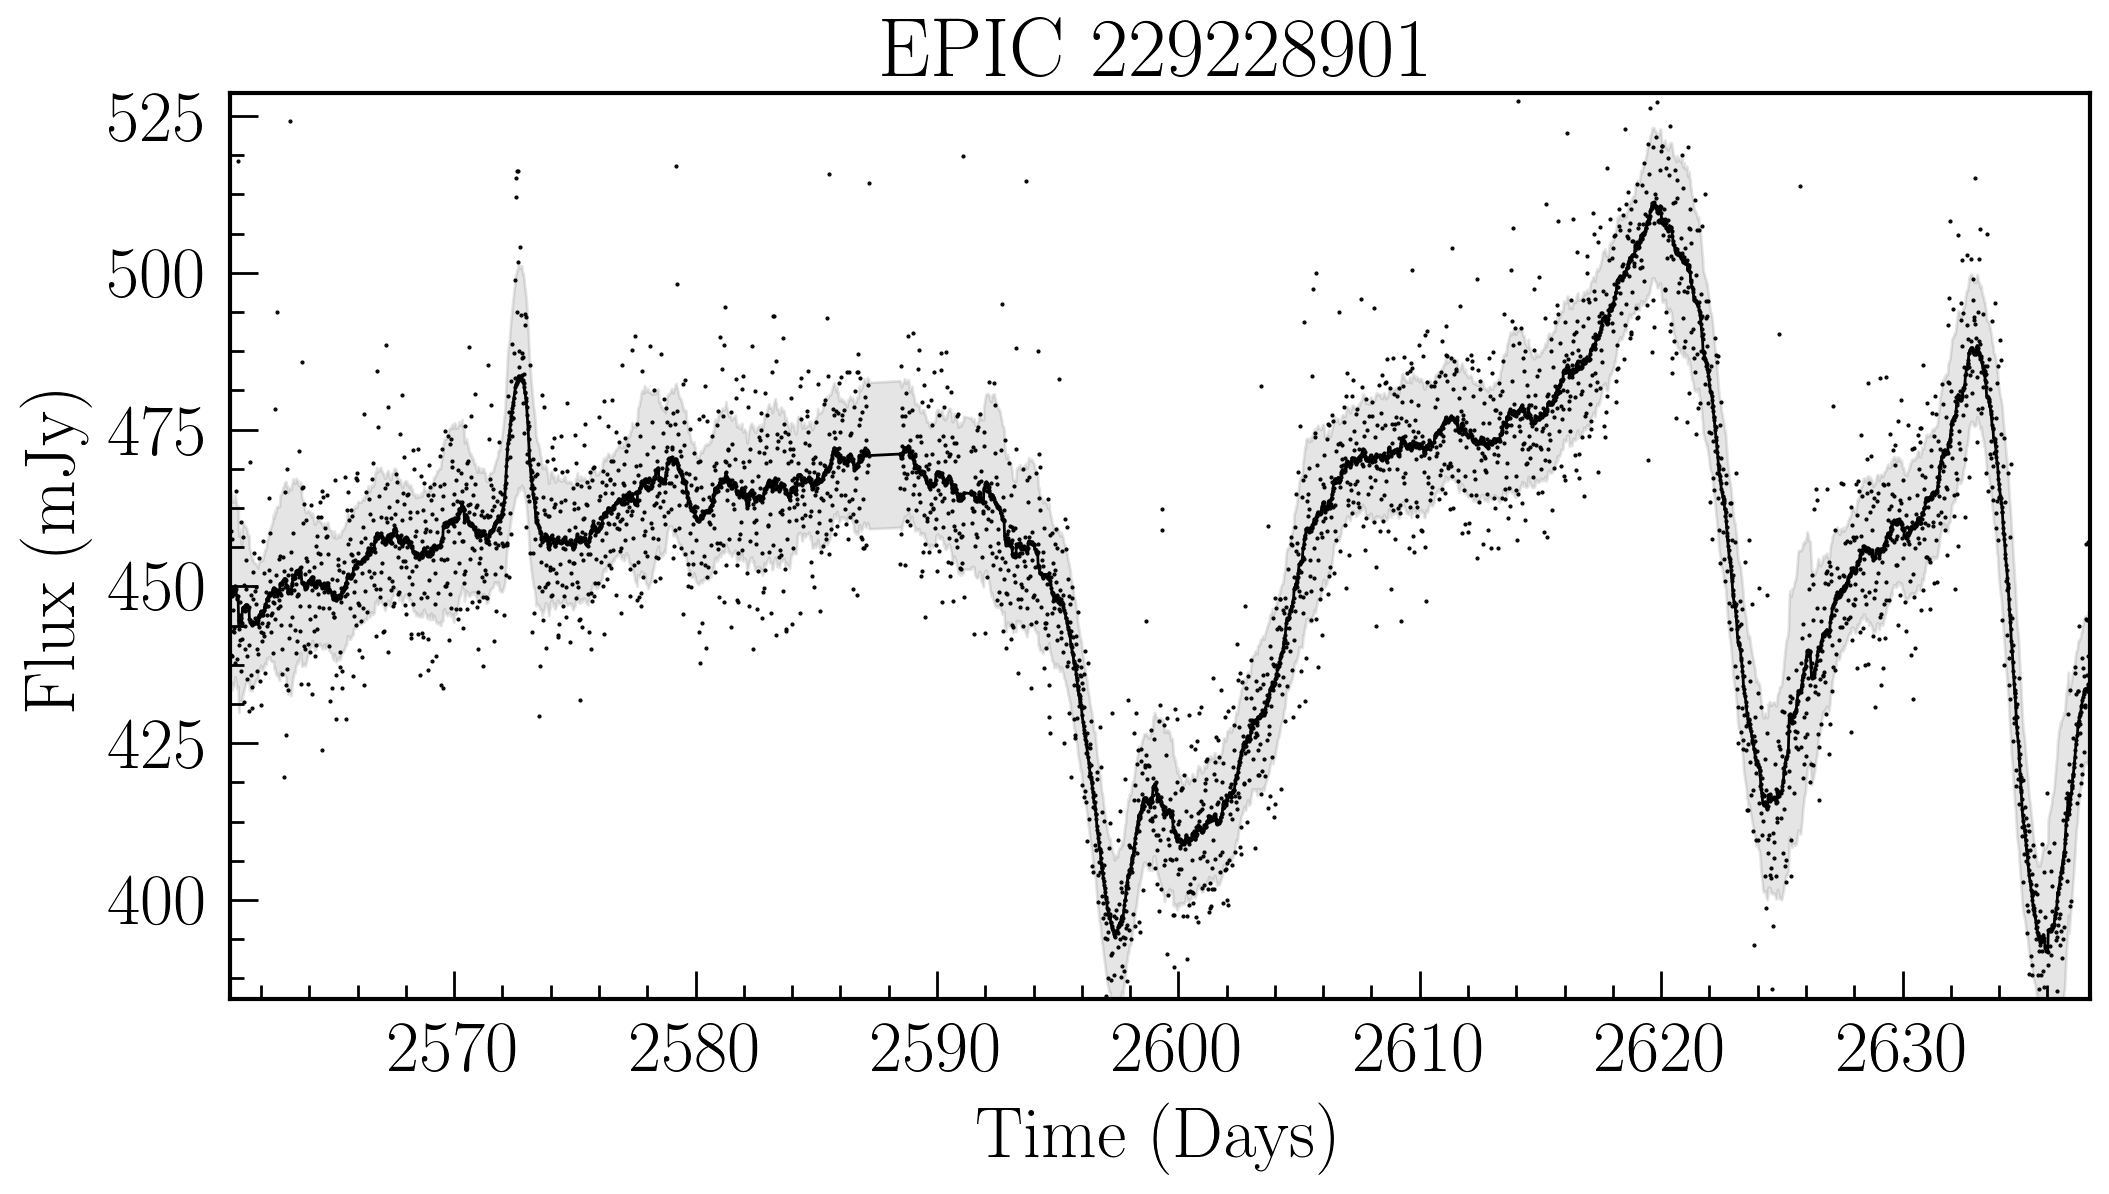

In [34]:
#Let's make a nice plot of a sample LC
import richardsplot as rplot
idxs=[0,1,2][:1]
N=len(idxs)
fig, axes = subplots(N,1, figsize=(12,6*N), dpi=200)
EPICS = [220176624,220178456,220179771]
axes=[axes]


for (ax, idx) in zip(axes, idxs):

    #idx = 3
    lcslist = LCDict_[8]['CIRC_APER4']
    ts, lcs = lcslist
    t = ts[idx]
    lc = lcs[idx]
    obj = shortEPIC_Lists[c].items()[idx]
    EPIC = obj[0]

    plotNiceIntervals(ax, t, lc, N=40, label = None, color='k')#'#d95f02')
    ax.set_title(r'$\mathrm{EPIC\ %i}$' % EPIC, fontsize=30)
    ax.set_xlabel(r"$\mathrm{Time\ (Days)}$", fontsize=24)
    ax.set_ylabel(r"$\mathrm{Flux\ (mJy)}$", fontsize=24)
    ax.xaxis.label.set_size(26)
    ax.yaxis.label.set_size(26)
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.title.set_size(30)
    set_tick_sizes(ax)


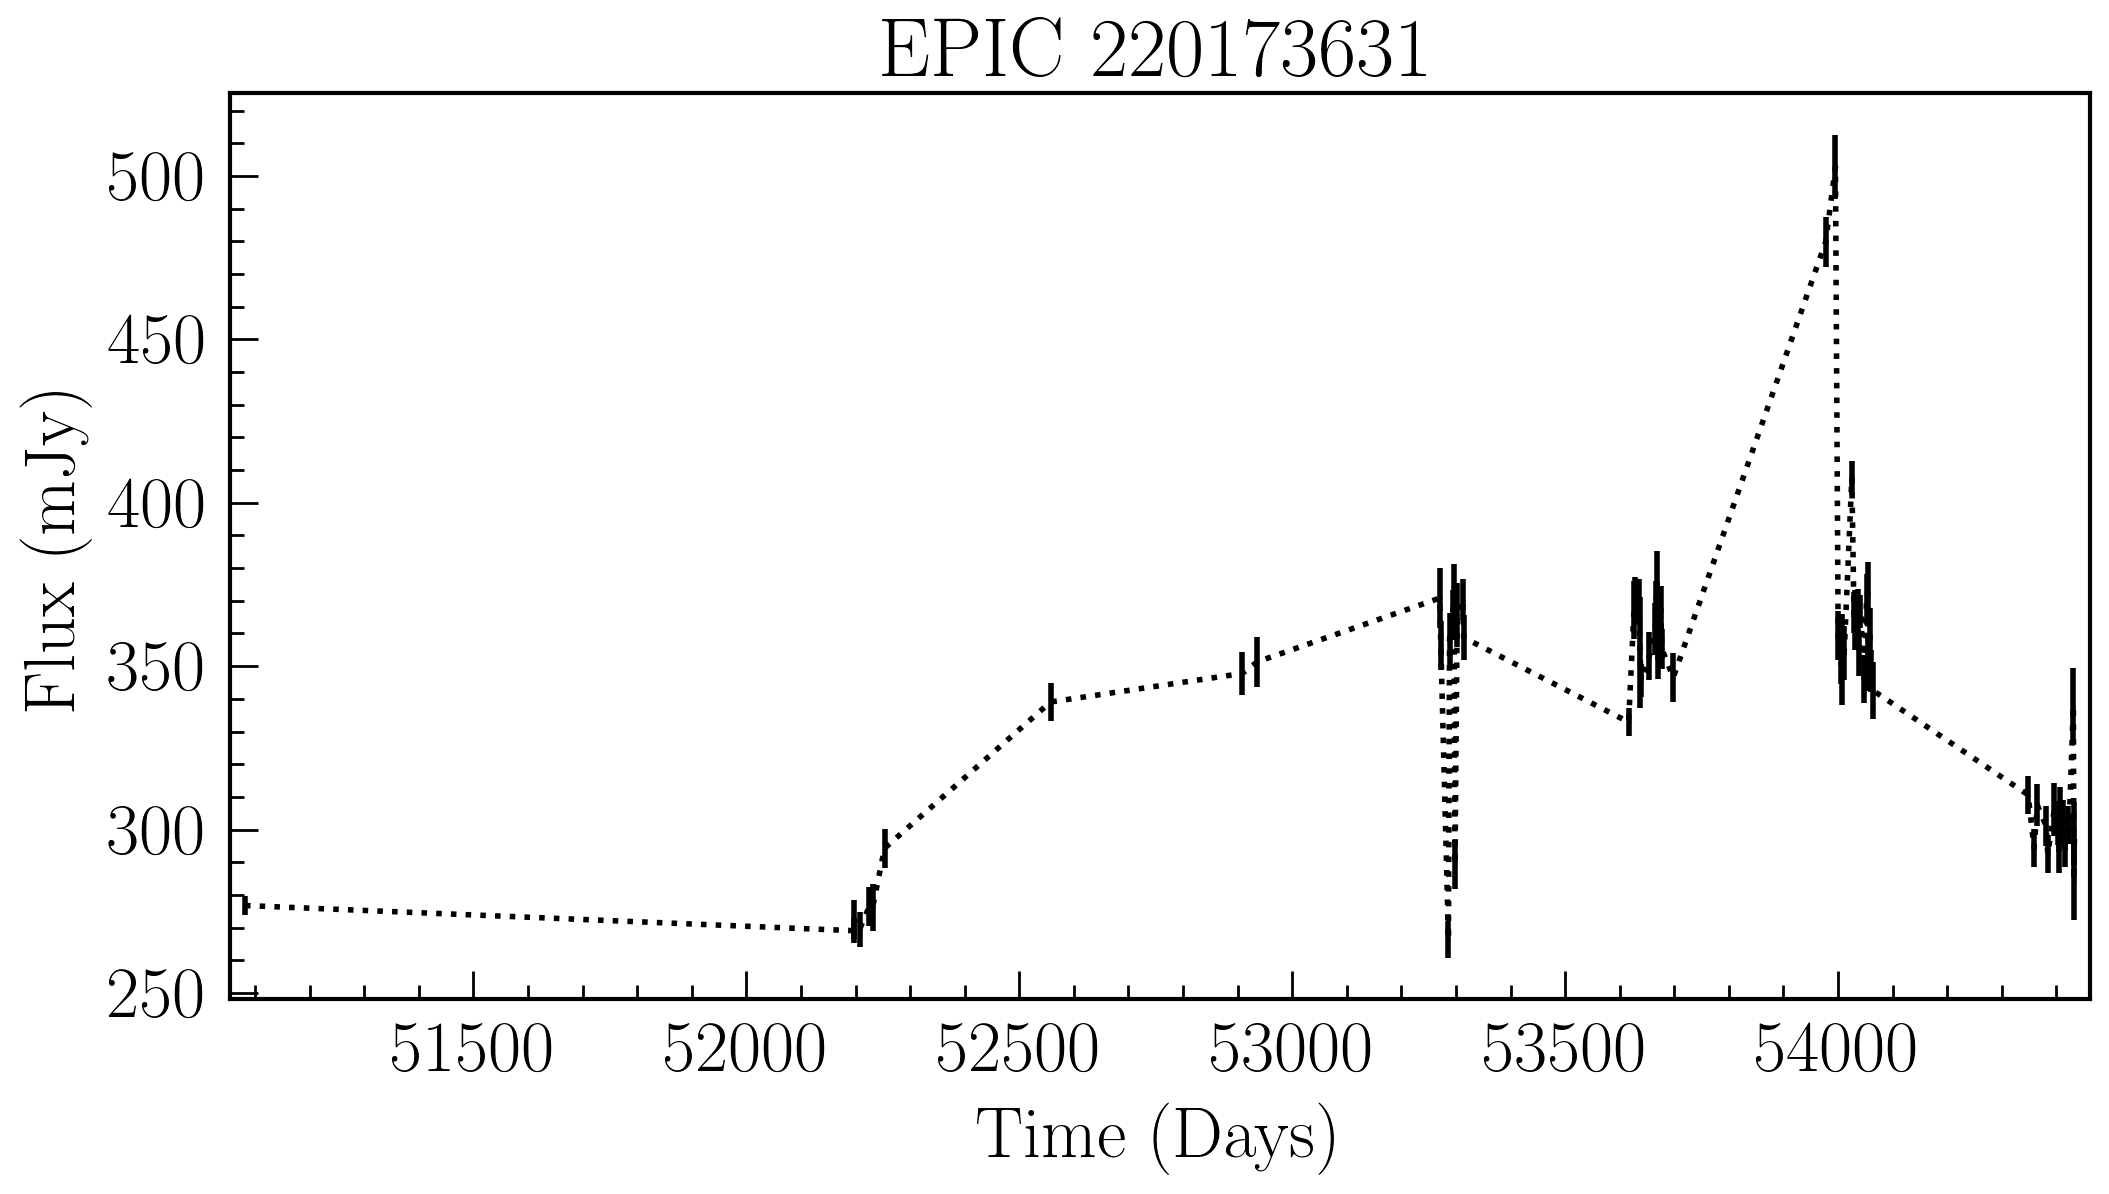

In [19]:
#make a nice SDSS plot
idx=0
from JacksTools import jio, jools
import glob
objs = glob.glob('/home/rodot/Documents/Research/Data/SDSS/*.csv')

objs = [o for o in objs if '42' in o]

f = jio.load(objs[idx], delimiter=',', headed=True)
t = f['mjd_g']
lcm = f['psfMag_g']
lcmerr = f['psfMagErr_g']

lc, lcerr = jools.luptitude_to_flux(lcm, lcmerr, 'g')
lc *= 1e6
lcerr*=1e6

fig, ax = subplots(1,1, figsize=(12,6), dpi=200)
#EPIC = re.findall(r'\d{9}', objs[idx])[0]
EPIC = '220173631'
def set_tick_sizes(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(26) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

def plotNiceIntervals2(ax,x,y, yerr,N=30, label=None, color='k'):
    rm = runningMean(y,N)
    #rs = runningStd(y,N)
    rs = runningMean(yerr,N) #Make it nice and smooth
    
    ax.errorbar(x, y, yerr, ls=':', marker='.', ms=1, color=color, label=label, lw=2)
    #ax.fill_between(x, rm+rs, rm-rs, color=color, alpha=0.1, linestyle='None')
    #ax.errorbar(x, rm, rs, ls='-', marker='.', ms=1, color=color, lw=1)
    r = max(x) - min(x)
    ax.set_xlim(min(x)-r/120.0, max(x)+r/120.0)

plotNiceIntervals2(ax, t, lc, lcerr, N=5,label = None, color='k')
ax.set_title(r'$\mathrm{EPIC\ %s}$' % EPIC, fontsize=30)
ax.set_xlabel(r"$\mathrm{Time\ (Days)}$", fontsize=24)
ax.set_ylabel(r"$\mathrm{Flux\ (mJy)}$", fontsize=24)
ax.xaxis.label.set_size(26)
ax.yaxis.label.set_size(26)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.title.set_size(30)
set_tick_sizes(ax)


(3385, 9)
(3385, 2)
(2, 9)


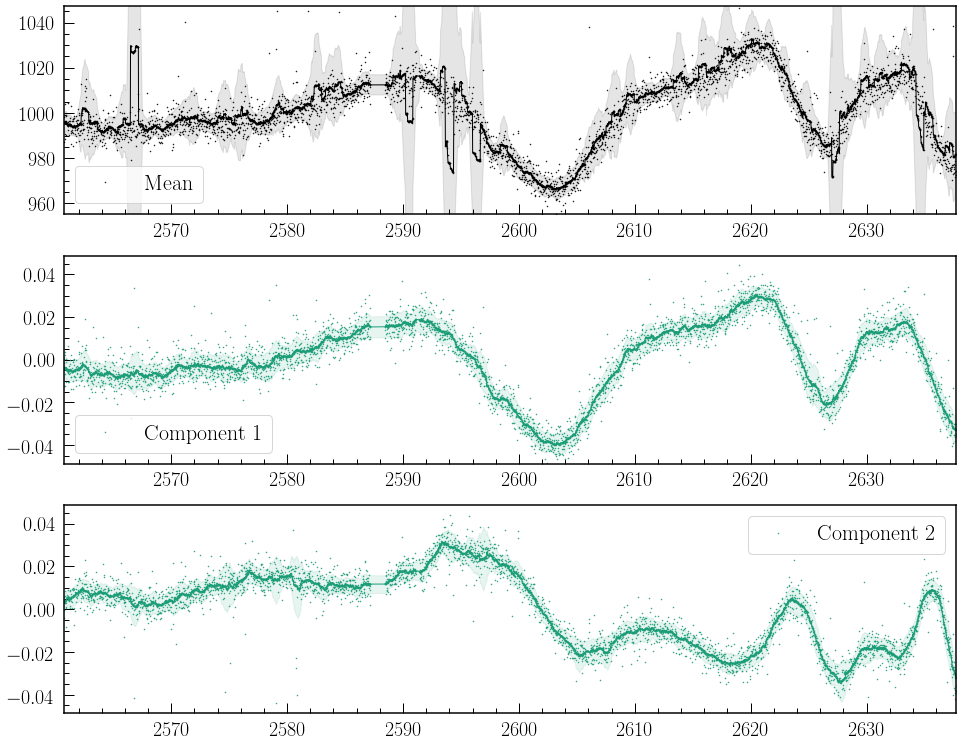

In [25]:
#Iteratively investigate weights


# ToDo: Filter out heavily weighted lightcurves
# Look at terms with negative kurtosis
# Use a kernel density estimator to build modelling function
# use tighter restrictions on magnitude for objects

# ICA weights dependent on magnitude go as A*(1-e^(-kx))
# So the corrected LC should be something like Original - A*(1-e^(-kx))*comp_{i}, where comp_{i} is the mag
#   dependent component and x is the magnitude

ap = 'CIRC_APER4'
c = 8
lcsList = LCDict_[c][ap]

lcs = np.array(lcsList[1][:39]).T
ts = lcsList[0][:39]

ncomp = 3

meanLC = lcs.mean(1)
meanLC = np.nanmean(lcs, axis=1)

ica = FastICA(ncomp - 1)
imp = Imputer(missing_values='NaN', strategy='median', axis=0) # Use an imputer to handle NaNs
imp.fit(lcs)
        
trans= imp.transform(lcs)
print trans.shape
X = ica.fit_transform(imp.transform(lcs))
print X.shape
weights = ica.components_
print weights.shape
fig, ax = subplots(ncomp,1, figsize=(16,9*ncomp/2))
plotNiceIntervals(ax[0],ts[0],meanLC,N=30, label='Mean', color='k')
ax[0].legend()
for i,a in enumerate(ax.flat):
    if i > 0:
        plotNiceIntervals(a,ts[0],X[:,i-1],N=30, label='Component %i' % (i), color=rplot.csdark[0])
        a.legend(prop={'size':22})
        a.xaxis.label.set_size(22)
        a.yaxis.label.set_size(22)
        a.tick_params(axis='both', which='major', labelsize=20)
        a.title.set_size(24)
ax[0].legend(prop={'size':22})   
ax[0].xaxis.label.set_size(22)
ax[0].yaxis.label.set_size(22)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].title.set_size(24)

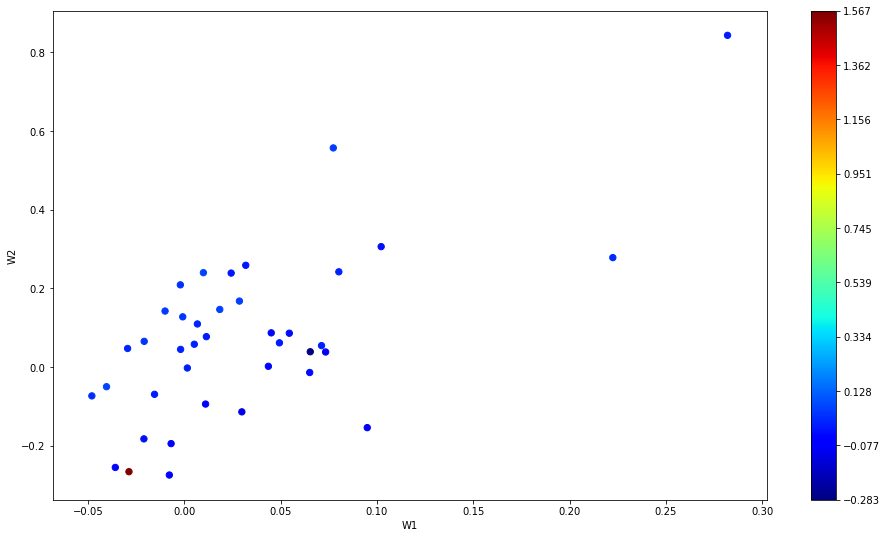

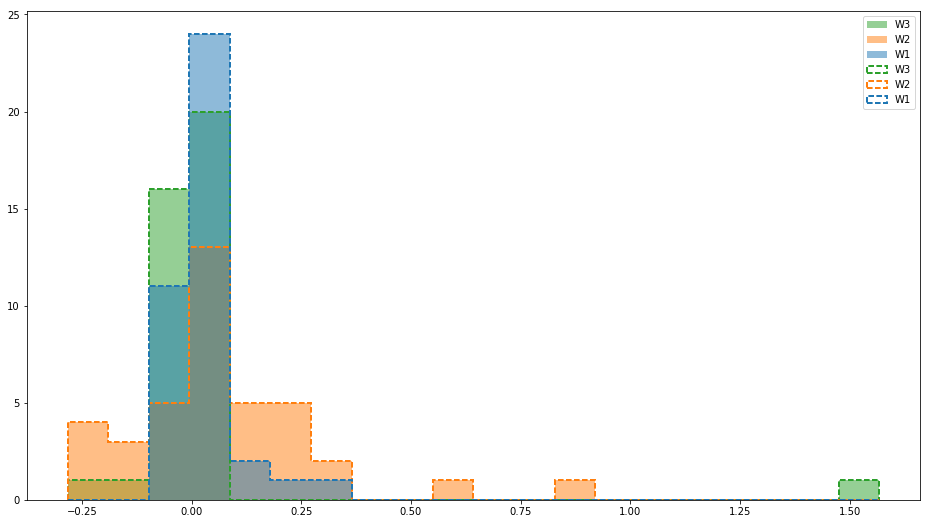

In [63]:
import matplotlib.pyplot as plt

fig, ax = subplots(1,1, figsize=(16,9))
cax = ax.scatter(weights[0], weights[1], c=weights[2], s=40, cmap='jet')
ax.set(xlabel='W1', ylabel='W2')
cbar = fig.colorbar(cax, ticks=np.linspace(min(weights[2]), max(weights[2]), 10))
fig2, ax2 = subplots(1,1, figsize=(16,9))
colors = ['g','o','b']
ax2.hist(weights.T, label = ['W%i'%(i+1) for i in xrange(weights.shape[0])], histtype='stepfilled', ls='--', bins=20, alpha=0.5)
plt.gca().set_color_cycle(None)
ax2.hist(weights.T, label = ['W%i'%(i+1) for i in xrange(weights.shape[0])], histtype='step', ls='--', bins=20, lw=2)

ax2.legend()

0
EPIC 220412416
Flux: 195231.211049
std: 0.0120908613717
Weight: [-0.01008535  0.14213314  0.05410736]
Weights [-0.01008535  0.14213314  0.05410736]
std_ratio: 0.350617955824
comp std: [ 0.02645355  0.02645355  0.02645355]
(3,) (3, 1429)
comp std ratio: 8.99620305434
Scale Factor: [-0.01008535  0.14213314  0.05410736]
  sum: 0.186155151158
----------------------------------------------
2
EPIC 220178439
Flux: 62308.7800559
std: 0.0161774168561
Weight: [-0.00786174 -0.27458579 -0.05999914]
Weights [-0.00786174 -0.27458579 -0.05999914]
std_ratio: 0.262048826214
comp std: [ 0.02645355  0.02645355  0.02645355]
(3,) (3, 1429)
comp std ratio: 6.52485276979
Scale Factor: [-0.00786174 -0.27458579 -0.05999914]
  sum: -0.342446671691
----------------------------------------------
4
EPIC 220248074
Flux: 38739.0751542
std: 0.0118614586023
Weight: [ 0.04356744  0.00170825 -0.03828379]
Weights [ 0.04356744  0.00170825 -0.03828379]
std_ratio: 0.357398970939
comp std: [ 0.02645355  0.02645355  0.02645

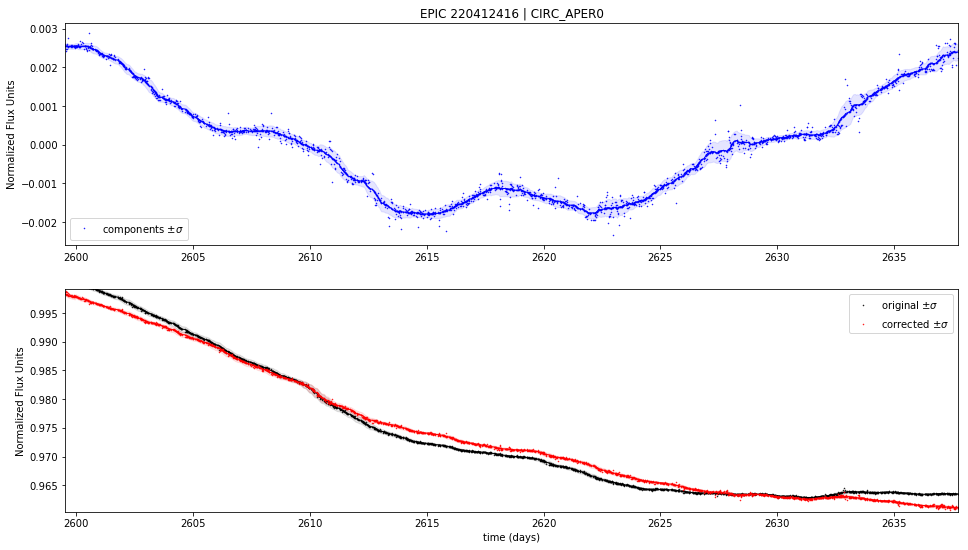

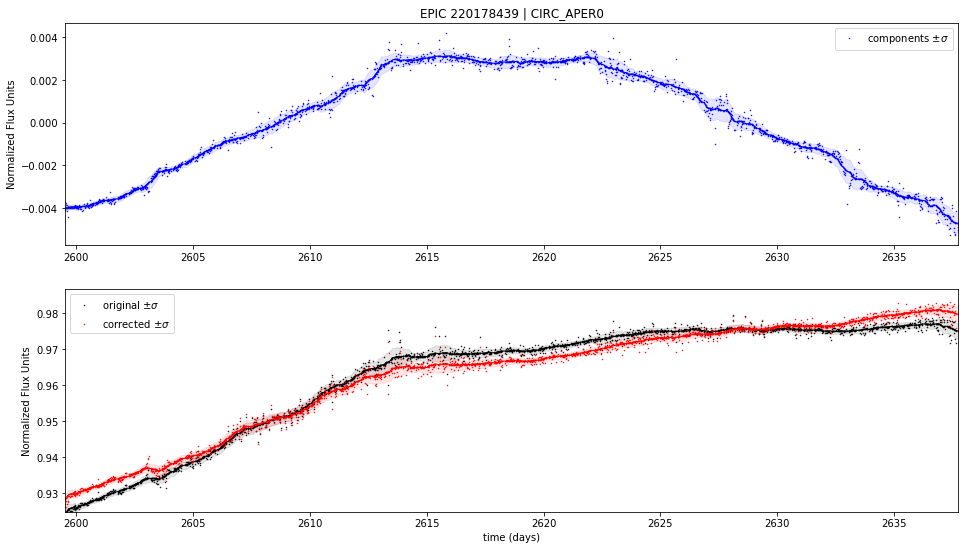

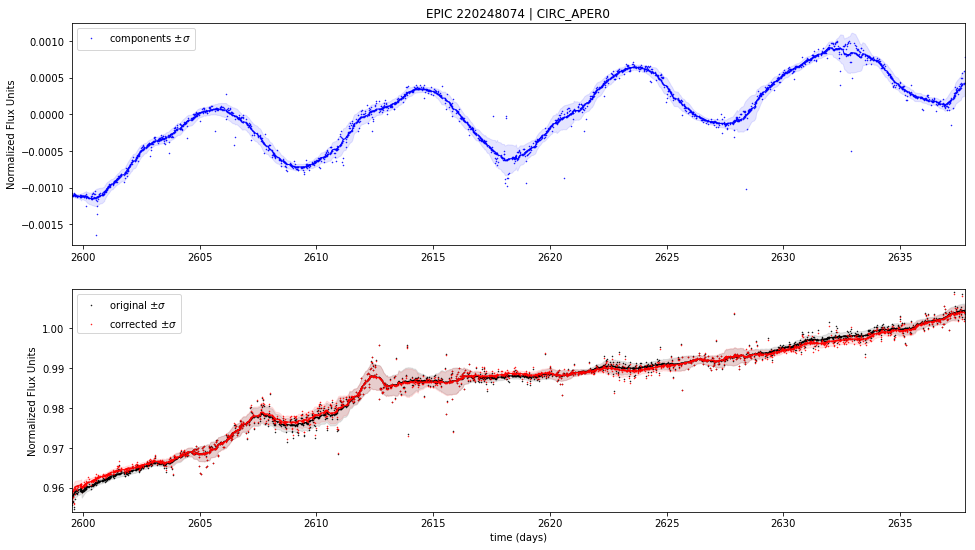

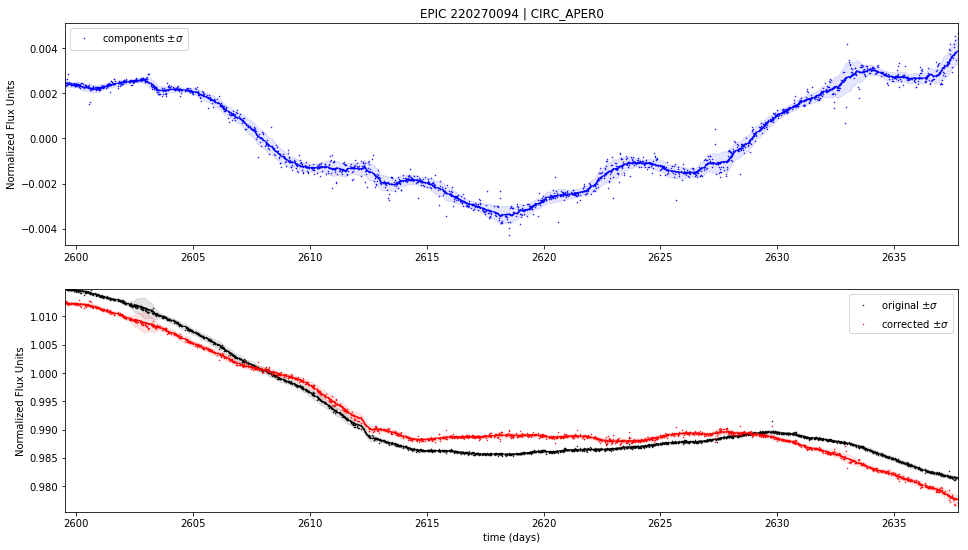

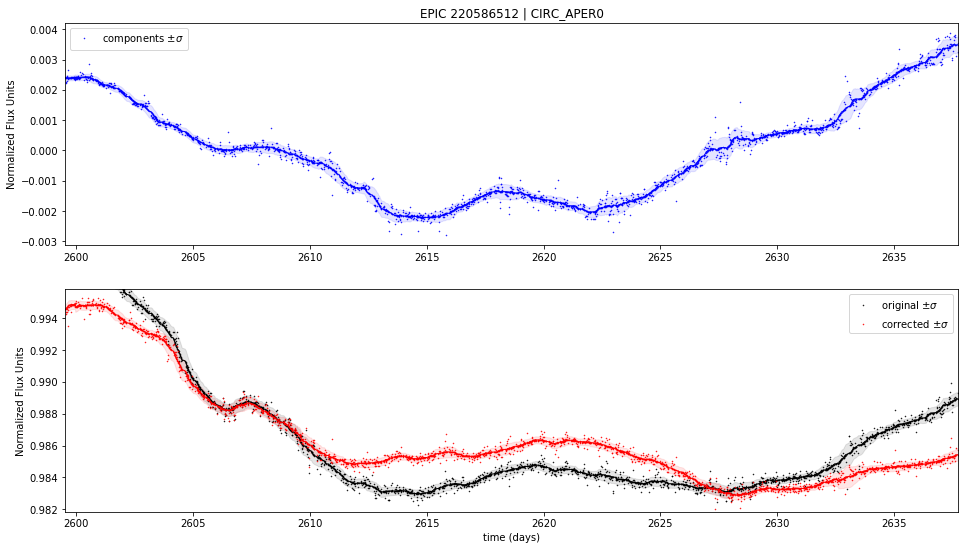

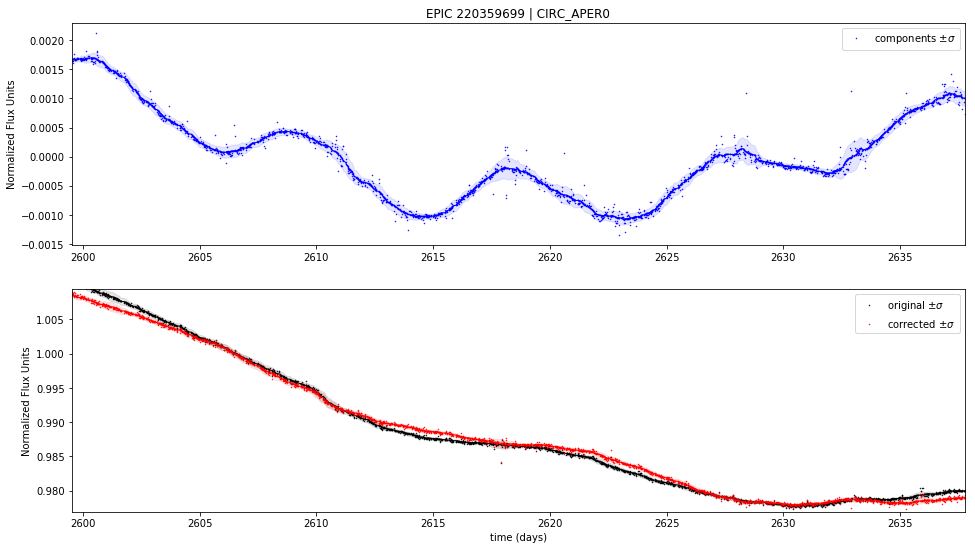

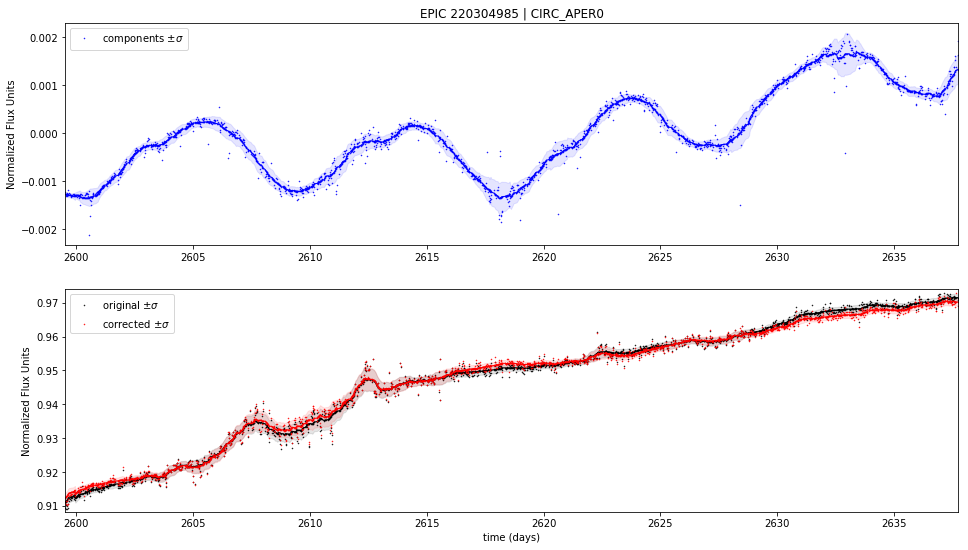

In [65]:
# ICA 2: electric boogaloo

c = 8
ap = 'CIRC_APER0'

def correctLC(idx, c=8, ap='CIRC_APER0'):
    order=9
    w_idx = range(weights.shape[0])

    #idx = np.argmin(np.abs(weights), axis=0)[w_idx]
    print idx

    lcsLists = LCDict[c][ap]
    lcs = lcsLists[1][idx]
    ts = lcsLists[0][idx]
    comps = np.array(X.T, copy=True)
    fig, ax = subplots(2,1, figsize=(16,9))
    obj = shortEPIC_Lists[c].items()[idx]
    print 'EPIC',obj[0]
    flux = magToFlux(obj[1][0])
    print 'Flux:',flux
    std = np.nanstd(lcs)
    mean = np.nanmean(lcs)
    print 'std:',std
    w = weights[w_idx,idx]
    #w *= 1.0/np.sum(w)
    print 'Weight:',w
    print "Weights", weights[:,idx]
    #std = np.mean(meanLC)/6
    std = np.nanstd(lcs)
    print "std_ratio:", np.nanstd(meanLC)/np.nanstd(lcs)
    std=1
    comp = np.array(comps[w_idx], copy=True)
    print "comp std:", np.std(comp, axis=1)
    #f = std/np.std(comp, axis=1)*w
    f=w
    #for i,col in enumerate('gkb'):
    #    plotNiceIntervals(ax[0], ts, comp[i]*w[i]*std/np.std(comp[i]), N=30, label='W%i'%(i+1), color=col)
    print f.shape, comp.shape
    comp = np.sum((comp.T*f).T, axis=0)/len(w)

    print 'comp std ratio:', np.nanstd(lcs)/np.nanstd(comp)
    print 'Scale Factor:',f
    print '  sum:', np.sum(f)
    #comp *= np.nanstd(lcs)/np.nanstd(comp)

    plotNiceIntervals(ax[0],ts,comp,N=30, label='components $\pm \sigma$', color='b')
    ax[0].legend()

    plotNiceIntervals(ax[1],ts,lcs,N=30, label='original $\pm \sigma$', color='k')
    plotNiceIntervals(ax[1],ts,lcs-comp,N=30, label='corrected $\pm \sigma$', color='r')

    rm = runningMean(lcs-comp, 30)
    rs = runningStd(lcs-comp, 30)
    ax[1].legend()
    ax[1].set_xlabel('time (days)')
    ax[1].set_ylabel('Normalized Flux Units')
    ax[0].set_ylabel('Normalized Flux Units')
    ax[1].set_xlim(min(ts), max(ts))
    ax[0].set_xlim(min(ts), max(ts))
    ax[1].set_ylim(min(rm-3*rs), max(rm+3*rs))
    ax[0].set_title('EPIC '+str(obj[0])+ ' | ' + ap)
    print '----------------------------------------------'
    
for idx in xrange(0,14,2):
    correctLC(idx, c=8, ap='CIRC_APER0')


LCs.shape: (50, 1429)
BESTAPER Campagin 8
Heighest Weighted LCs: [(220223508, 0.97457050566309578), (220398184, 0.95754008160741344), (220392515, 0.46784049763626628)]
Max Weights: [ 1.1204522   1.07711984  0.70756629]
Kurtosis: [ 42.12906399  39.06249468   1.93828233]
Correlated Component: W3
  s = 2.75558981447e-07
  i = 0.0159375624801
  r^2 = 0.01159761344
  polyfit: [  5.40871860e+06  -6.19737297e+03   1.57836344e+00   6.02274553e-04
  -3.45122436e-07   4.39377033e-11]


/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


LCs.shape: (50, 1429)
CIRC_APER0 Campagin 8
Heighest Weighted LCs: [(220398184, 0.8782225343155452), (220211740, 0.35714373129055471), (220507824, 0.35090246423783289)]
Max Weights: [ 1.07090698  0.5927264   0.51294572]
Kurtosis: [ 26.91379915  -0.27671571  -0.11680657]
Correlated Component: W2
  s = 2.77169682921e-07
  i = 0.000443836434713
  r^2 = 8.99436960496e-06
  polyfit: [  3.84215793e+05  -4.40942518e+02   1.12586648e-01   4.28609094e-05
  -2.46223392e-08   3.13942994e-12]


/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


LCs.shape: (50, 1429)
CIRC_APER4 Campagin 8
Heighest Weighted LCs: [(220442637, 0.53647300373272755), (220223508, 0.93167783070592236), (220398184, 0.96675694680182722)]
Max Weights: [ 0.93962646  1.15131382  1.02986191]
Kurtosis: [  3.5804795   34.82669788  40.6911139 ]
Correlated Component: W1
  s = 2.74591366801e-07
  i = 0.0201436865373
  r^2 = 0.0185268991607
  polyfit: [ -4.72839381e+07   5.41269399e+04  -1.37636541e+01  -5.25957965e-03
   3.00915345e-06  -3.82721011e-10]


/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


LCs.shape: (50, 1429)
CIRC_APER9 Campagin 8
Heighest Weighted LCs: [(220442637, 0.47210190886982689), (220223508, 0.96326277327965193), (220398184, 0.98712373235032946)]
Max Weights: [ 0.91635697  1.09059375  1.0291648 ]
Kurtosis: [  3.36693924  40.08594043  44.47497331]
Correlated Component: W1
  s = 2.7396289188e-07
  i = 0.0224511276715
  r^2 = 0.0230144789888
  polyfit: [ -2.69470816e+07   3.08299316e+04  -7.83250916e+00  -2.99558124e-03
   1.71230080e-06  -2.17657280e-10]


/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


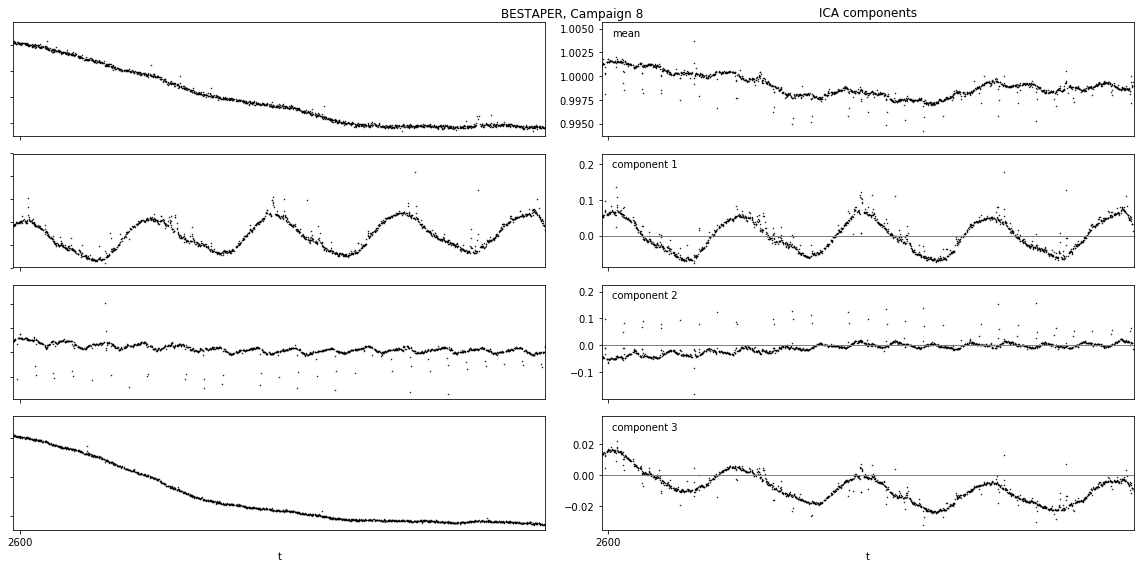

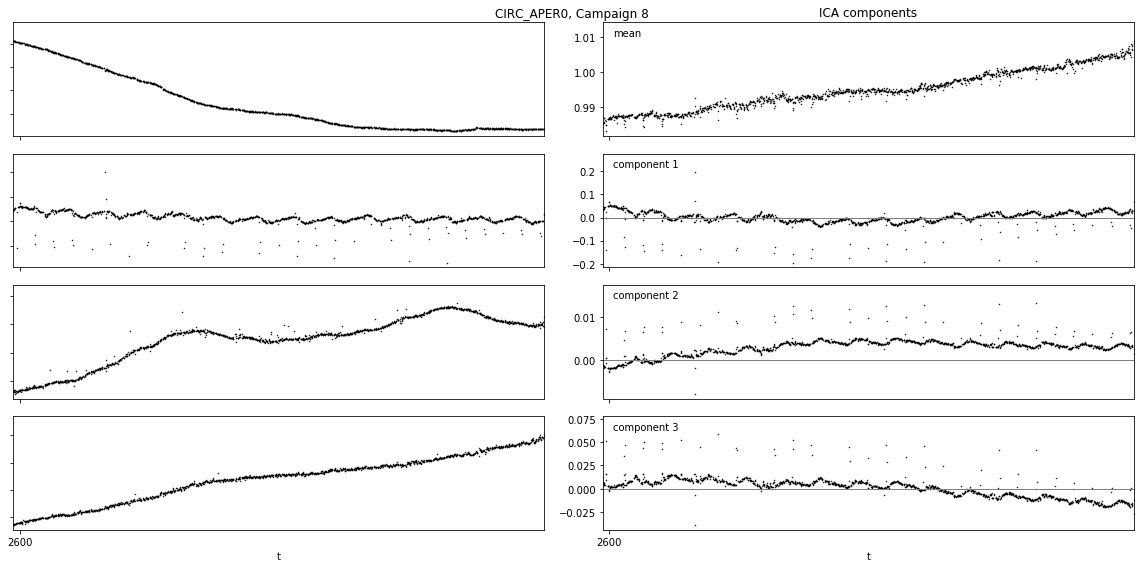

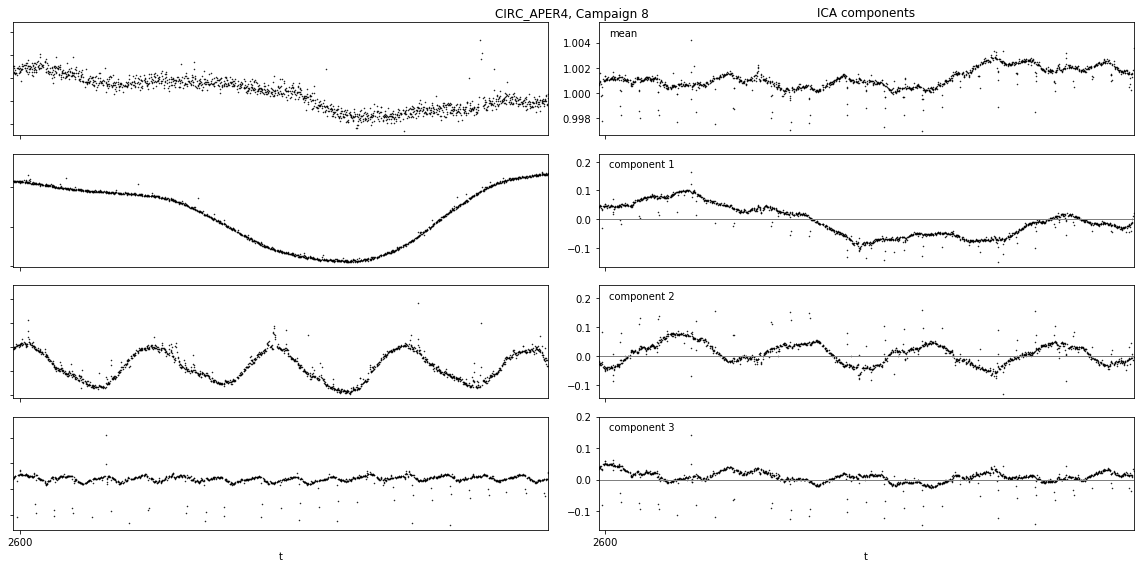

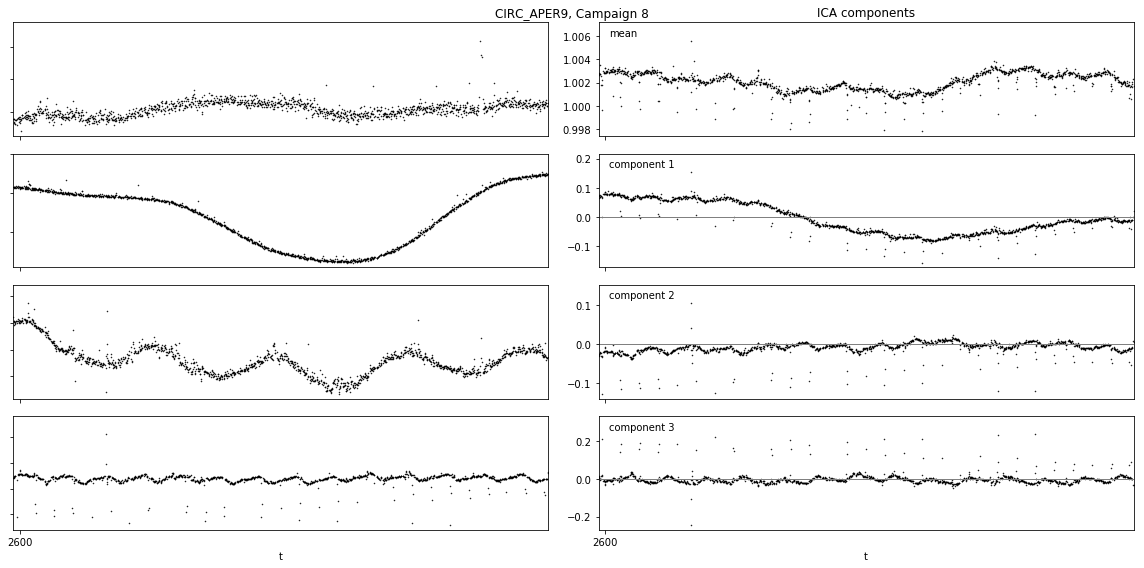

In [58]:
ICA_DICT = {}

for k, ap in enumerate(aps):
    ICA_DICT[ap] = {}
    for c in campaigns: 
        
        #if i < 7:
        #    continue
        
        campaign = 8
        lcsLists = LCDict[c][ap]
        lcs = lcsLists[1]
        ts = lcsLists[0]
        
        LCs = np.vstack(lcs)
        print "LCs.shape:",LCs.shape
        Ts = np.vstack(ts)
        print ap, "Campagin %i" % campaign

        #----------------------------------------------------------------------
        # Compute ICA
        np.random.seed(42)
        
        ncomp = 4
        order=5

        meanLC = LCs.mean(0)
        meanLC = np.nanmean(LCs, axis=0)

        ica = FastICA(ncomp - 1)
        imp = Imputer(missing_values='NaN', strategy='mean', axis=1) # Use an imputer to handle NaNs
        imp.fit(LCs)
        
        #weights = ica.fit_transform(LCs)
        trans= imp.transform(LCs)
        weights = ica.fit_transform(imp.transform(LCs))
        #print weights.shape
        
        #Write out to csv
        header = 'EPIC,KepMag,KepFlux,RA,DEC,'+','.join(['W%i'%(i+1) for i in xrange(len(weights[0]))])
        body=[]
        for lc, w in zip(shortEPIC_Lists[c].items(), weights):
            line = [lc[0],lc[1][0],magToFlux(float(lc[1][0])),lc[1][1],lc[1][2]]+list(w)
            line = ','.join(map(str, line))
            body.append(line)
        body = '\n'.join(body)
        with open("K2ICA_Weights_%s.csv" % ap,'w') as f: #write the weights to a file
            f.write('\n'.join((header,body)))
        

        
        keys = np.array(shortEPIC_Lists[c].keys())
        argmax = np.argmax(np.abs(weights), axis=0)
        max_items = keys[argmax]
        print "Heighest Weighted LCs:",zip(max_items, np.max(np.abs(weights), axis=0))
        print "Max Weights:",np.max(weights, axis=0) - np.min(weights, axis=0)
        print "Kurtosis:",kurtosis(weights, axis=0)
        print "Correlated Component:", 'W'+str(np.argmin(kurtosis(weights, axis=0))+1)
        # Now we'll compute the relationship
        idx = np.argmin(kurtosis(weights, axis=0))
        w, flux = zip(*((w[idx],magToFlux(float(lc[1][0]))) for lc, w in zip(shortEPIC_Lists[c].items(), weights)))
        s, i, r, p, s = linregress(flux, w)
        print "  s =", s
        print "  i =", i
        print "  r^2 =", r**2 

        coefs = polyfit(ts[0], ica.components_[idx], order)[::-1]
        print "  polyfit:", coefs
        #continue
        ICA_DICT[ap][c] = (weights, ica.components_, coefs)

        ica_comp = np.vstack([meanLC,ica.components_]) #Add the mean to the components

        with open("K2ICA_Components_%s.csv" % ap, 'w') as f:
            t = Ts[0]
            header='T,mean,'+','.join(['C_%i' % (i+1) for i in xrange(len(weights[0]))])
            lines = np.vstack(([t], ica_comp)).T
            body = []
            for line in lines:
                body.append(','.join(map(str,line)))
            body = '\n'.join(body)
            body = '\n'.join((header, body))
            f.write(body)
            
        
        #Make plots
        fig = plt.figure(figsize=(16,2*ncomp))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

        fig.suptitle("%s, Campaign %i" % ( ap, campaign))
        titles = 'ICA components'

        for j in range(ncomp):
    
            n = j
            if j > 0 and j <= len(argmax):
                n = argmax[j-1]
            # plot the components
            ax = fig.add_subplot(ncomp, 2, 2*j+2)
            #ax.yaxis.set_major_formatter(plt.NullFormatter())
            ax.xaxis.set_major_locator(plt.MultipleLocator(100))
            if j < ncomp - 1:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
            else:
                ax.set_xlabel('t')
            ax.plot(Ts[j], ica_comp[j], '-k', ls=' ', marker='.', ms=1)
            #if j == idx + 1:
                #ax.plot(Ts[j], [np.sum(t**n*coefs[n] for n in xrange(order+1)) for t in Ts[j]], color='b', lw=2)
            # plot zero line
            xlim = [min(Ts[j]), max(Ts[j])]
            ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
            ax.set_xlim(xlim)

            # adjust y limits
            ylim = plt.ylim()
            ylim = [min(ica_comp[j]), max(ica_comp[j])]
            dy = 0.05 * (ylim[1] - ylim[0])    
            ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)

            # plot the first j spectra
            ax2 = fig.add_subplot(ncomp, 2, 2*j+1)
            ax2.yaxis.set_major_formatter(plt.NullFormatter())
            ax2.xaxis.set_major_locator(plt.MultipleLocator(100))
            if j < ncomp - 1:
                ax2.xaxis.set_major_formatter(plt.NullFormatter())
            else:
                ax2.set_xlabel('t')
            ax2.plot(Ts[n], LCs[n], '-k', ls=' ', marker='.', ms=1)
    
            # plot zero line
            ax2.plot(xlim, [0, 0], '-', c='gray', ls=' ', marker='.', ms=1)
            ax2.set_xlim(xlim)

            if j == 0:
                ax.set_title(titles, fontsize='large')

            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j

            # adjust y limits
            ylim = plt.ylim()
            ylim = [min(LCs[n]), max(LCs[n])]
            dy = 0.05 * (ylim[1] - ylim[0])    
            ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


            ax.text(0.02, 0.95, label, transform=ax.transAxes,
                    ha='left', va='top', bbox=dict(ec='w', fc='w'),
                    fontsize='medium')
        fig.tight_layout()
        plt.savefig("/home/rodot/Documents/Research/Plots/K2/ICA/%s.png" % ''.join((("Campaign%i "%campaign),ap)))
        #plt.show()

[22 23 14]
EPIC 220350993
Flux: 31228.3651069
std: 0.000768860088364
Weight: [-0.01104269  0.03167038  0.02342766]
Weights [-0.01104269  0.03167038  0.02342766]
(3,) (3, 1429)
Scale Factor: [-0.01104269  0.03167038  0.02342766]


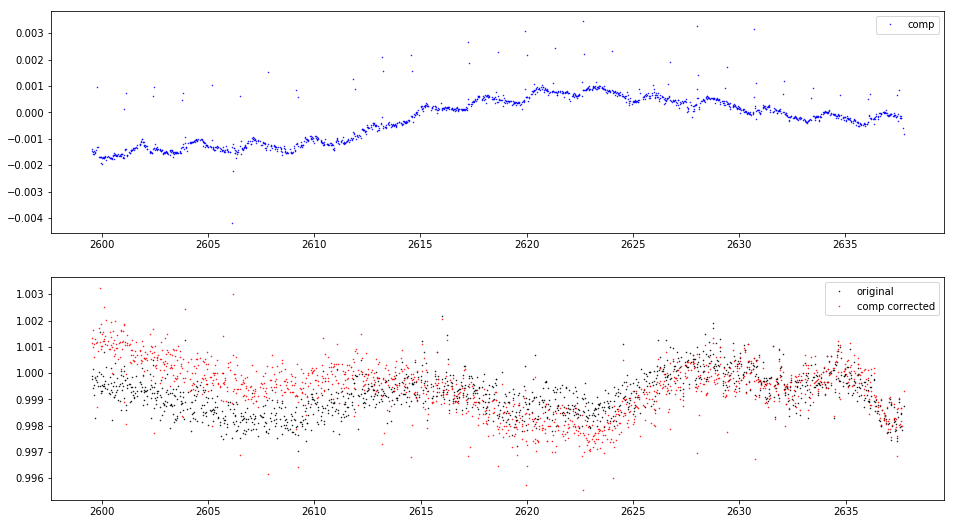

In [59]:
#Let's plot some sample lightcurves that are corrected

c = 8
ap = 'CIRC_APER9'
weights, comps, coefs = ICA_DICT[ap][c]
order=9
w_idx = range(weights.shape[1])
#w_idx=[1]
#w_idx=[0]
idx = np.argmin(np.abs(weights), axis=0)[w_idx]
print idx
idx = 9
lcsLists = LCDict[c][ap]
lcs = lcsLists[1][idx]
ts = lcsLists[0][idx]

fig, ax = subplots(2,1, figsize=(16,9))
obj = shortEPIC_Lists[c].items()[idx]
print 'EPIC',obj[0]
flux = magToFlux(obj[1][0])
print 'Flux:',flux
std = np.nanstd(lcs)
mean = np.nanmean(lcs)
print 'std:',std
w = weights[idx][w_idx]
#w *= 1.0/np.sum(w)
print 'Weight:',w
print "Weights", weights[idx]
#std = np.mean(meanLC)/6
std=1

#print (comps[[0,1]].T*weights[idx][[0,1]]).T
#comp = np.array(np.sum((comps[[0,1,2]].T*weights[idx][[0,1,2]]/np.std(comps[[0,1,2]], axis=1)).T, axis=0), copy=True)

comp = np.array(comps[w_idx], copy=True)
f = std/np.std(comp, axis=1)*w
f=w
print f.shape, comp.shape
comp = np.sum((comp.T*f).T, axis=0)
#comp *= f
#fit = np.array([np.sum(t**n*coefs[n] for n in xrange(order+1))\
#             for t in ts])*f
#fit *= f
print 'Scale Factor:',f


#ax[0].plot(ts, fit, color='b', lw=2, label='fit')
ax[0].plot(ts, comp, ls=' ', marker='.', ms=1, color='b', label='comp')
ax[0].legend()
ax[1].plot(ts, lcs, marker='.', ls=' ', ms=1, color='k', label='original')
#ax[1].plot(ts, lcs-fit, marker='.', ls=' ', ms=1, color='b', label='fit corrected')
ax[1].plot(ts, lcs-comp, marker='.', ls=' ', ms=1, color='r', label='comp corrected')
ax[1].legend()


In [ ]:
# Run ICA on objects in certain area
# Maybe use all weights that are least contributing?  
#  we want weights that largly contribute to all objects

In [ ]:
# For this, it looks like I want some linear function
#  of the following form:
# obj_{i}(t) = w_{i,j}*comp_{j}(t)+trueLC_{i}(t)
# j=component index
# i=object numer
# t=timestep

In [ ]:
# Lets plot some weights
ap = 'CIRC_APER9'
weights, comps, coefs = ICA_DICT[ap][c]
fig, ax = subplots(1,1, figsize=(16,9))
#ax.hist(weights[:,2][weights[:,2]> -1.8])
ax.scatter(weights[:,0], weights[:,1], c=weights[:,2], cmap='jet', s=2)
#for line in weights:
#    print line

In [ ]:
# Let's cross correlate some light curves to see if this systematic error is time-shifted

from scipy.signal import correlate

ap = 'CIRC_APER4'
c=8
lcsLists = LCDict[c][ap]
corrs = []
fig, ax = subplots(2,1,figsize=(16,10))
ra1 = []
dec1 = []
ra2 = []
dec2 = []
mag1 = []
mag2 = []
w1 = []
w2 = []
widx=1
for idx1 in range(20):
    for idx2 in range(idx1+1,20):

        w1.append(weights[idx1][widx])
        w2.append(weights[idx2][widx])
        LC1 = lcsLists[1][idx1]
        COORD1 = shortEPIC_Lists[c].items()[idx1]
        ra1.append(COORD1[1][1])
        dec1.append(COORD1[1][2])
        mag1.append(COORD1[1][0])
        LC2 = lcsLists[1][idx2]
        COORD2 = shortEPIC_Lists[c].items()[idx2]
        ra2.append(COORD2[1][1])
        dec2.append(COORD2[1][2])
        mag2.append(COORD2[1][0])
        t = lcsLists[0][idx1]
        #if w1[-1] > 0.5:
        #    ax[0].plot(t, LC1, marker='.', ls=' ', ms=1)



        #mask = ~(np.isnan(LC1) | np.isnan(LC2))
        #corr = correlate(LC1[mask], LC2[mask], mode='full')/np.sum(mask)

        #t_corr = t[mask] - min(t[mask])
        #t_corr = np.concatenate((-t_corr[1:][::-1], t_corr))
        #print len(t_corr), len(corr)
        #corrs.append(t_corr[np.argmax(corr)])

#ax[0].plot(np.nanmean(lcsLists[0], axis=0),np.nanstd(lcsLists[1], axis=0), ls = ' ', marker='.', ms=1) 
#ax[0].set_ylim(0, 0.1)
#ax[0].plot(t_corr, corr)
#ax[0].plot(t-min(t), LC1 , marker='.', ls=' ', ms=1)
#ax[0].plot(t-min(t), LC2, marker='.', ls=' ', ms=1)

def argbin(x, N):
    bin_range = max(x)-min(x)
    bin_idx = np.linspace(min(x), max(x)+min(np.abs(x[1:]-x[:-1]))/2.0, N+1)
    bin_masks = np.array([(x >= bin_idx[n]) & (x < bin_idx[n+1]) for n in xrange(N)])
    print bin_idx
    def bin_func(y):
        return [y[bin_masks[n]] for n in xrange(N)]

    return bin_func
        

w1 = np.array(w1)
w2 = np.array(w2)
corrs = np.array(corrs)  
ra1 = np.array(ra1)
ra2 = np.array(ra2)
dec1 = np.array(dec1)
dec2 = np.array(dec2)
mag1 = np.array(mag1)
mag2 = np.array(mag2)
ax[0].scatter(np.sqrt((ra1-ra2)**2+(dec1-dec2)**2), np.abs(w1-w2))
ax[1].scatter(np.arctan2((dec1-dec2), (ra1-ra2)), np.abs(w1-w2))
#bin10 = argbin(np.abs(w1-w2), 10)
#corr_bin = bin10(corrs)
#w_bin = bin10(np.abs(w1-w2))
#print w_bin
#w = np.array(map(np.min, w_bin))

#c = np.array(map(np.mean, corr_bin))
#print c
#ax[1].scatter(w, c)
#ax[1].scatter(np.abs(w1-w2), corrs, s=1, color='r')
print corrs

    


In [ ]:
# test numpy correlate
t = np.arange(1000)/1000.0*8*np.pi
x1 = np.sin(t)+np.random.randn(1000)
x2 = np.sin(t)+ np.random.randn(1000)
t_full = np.concatenate((-t[1:][::-1], t))
#print t_full[np.argmax(corr)]
print 8*np.pi/50

In [ ]:
t2 = t[10:-10]
t_full = np.concatenate((-t2[1:][::-1], t2))
corr = np.correlate(x1[10:], x2[:-10], mode='full')
print t_full[np.argmax(corr)]

In [ ]:
fig, ax = subplots(1,1)
#corrs = np.array(corrs)

ax.hist(corrs, bins=20)